In [5]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np
from sklearn.model_selection import train_test_split
print("Tensorflow version: "+ tf.__version__)

Tensorflow version: 2.11.0


In [6]:
COLAB=False
GPU=True

if COLAB==True and GPU==True:
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))
    tf.device('/device:GPU:0')

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])
    except RuntimeError as e:
        print(e)

In [8]:
# Google file system

if COLAB==True:
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))
    from google.colab import drive
    drive.mount('/GoogleDrive', force_remount=True)
    ATT_FILE =   "/GoogleDrive/My Drive/Colab Notebooks/RedesNeuronales/datasets/Fifa/FootballPlayerPreparedCleanAttributes.csv"
    LABEL_FILE = "/GoogleDrive/My Drive/Colab Notebooks/RedesNeuronales/datasets/Fifa/FootballPlayerOneHotEncodedClasses.csv"

else:
    ATT_FILE =   "datasets/FootballPlayerPreparedCleanAttributes.csv"
    LABEL_FILE = "datasets/FootballPlayerOneHotEncodedClasses.csv"

attributes = pd.read_csv(ATT_FILE)
label =      pd.read_csv(LABEL_FILE)

## Datasets

In [9]:
TRAIN_RATE = 0.8

n_instances = attributes.shape[0]

n_train = int(n_instances*TRAIN_RATE)
n_dev = int((n_instances-n_train)/2)
n_final_test = n_instances-n_train-n_dev

In [10]:
print("Total:", n_instances, "| Train:", n_train, "| Dev Test:", n_dev," | Final Test:", n_final_test)

Total: 16122 | Train: 12897 | Dev Test: 1612  | Final Test: 1613


In [14]:
datasplit=False

if datasplit==True:
    x_train, X_test, t_train, y_test = train_test_split(attributes,label,
                                                        test_size=0.2,
                                                        random_state=1992,
                                                        stratify=label)

    x_final_test, x_dev, t_final_test, t_dev = train_test_split(X_test,y_test,
                                                test_size=0.5,
                                                random_state=1992,
                                                stratify=y_test)
    INPUTS = x_train.shape[1]
    OUTPUTS = t_train.shape[1]

else:
    x_train = attributes.values[:n_train]
    t_train = label.values[:n_train]

    x_dev = attributes.values[n_train:n_train + n_dev]
    t_dev = label.values[n_train:n_train + n_dev]

    x_final_test = attributes.values[n_train+n_dev:n_instances]
    t_final_test = label.values[n_train+n_dev:n_instances]

    INPUTS = x_train.shape[1]
    OUTPUTS = t_train.shape[1]

In [15]:
print ("X_train:", x_train.shape, "| T_train:", t_train.shape)
print ("X_dev:", x_dev.shape, "| T_dev:", t_dev.shape)
print ("X_test:", x_final_test.shape, "| T_test:", t_final_test.shape)

X_train: (12897, 17) | T_train: (12897, 4)
X_dev: (1612, 17) | T_dev: (1612, 4)
X_test: (1613, 17) | T_test: (1613, 4)


## Model

In [16]:
n_neurons_per_layer = [512,1024,125,75,8] 
learning_rate = 0.01
n_epochs = 500
batch_size = 1024

In [17]:
model = keras.Sequential(name = "FifaNetwork")

In [286]:
from keras.layers import LeakyReLU

LeakyRelu=True

model.add(keras.layers.InputLayer(input_shape=(INPUTS,)))

for neurons in n_neurons_per_layer:
    if isinstance(neurons, int):
        if LeakyRelu==True:
            model.add(keras.layers.Dense(neurons))
            model.add(LeakyReLU(alpha=0.9))
        else:
            model.add(keras.layers.Dense(neurons, activation="relu"))
    else:
        model.add(keras.layers.Dropout(rate=neurons))

model.add(keras.layers.Dense(OUTPUTS, activation="softmax"))

In [287]:
model.summary()

Model: "FifaNetwork"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_154 (Dense)           (None, 512)               9216      
                                                                 
 dense_155 (Dense)           (None, 1024)              525312    
                                                                 
 dense_156 (Dense)           (None, 125)               128125    
                                                                 
 dense_157 (Dense)           (None, 75)                9450      
                                                                 
 dense_158 (Dense)           (None, 8)                 608       
                                                                 
 dense_159 (Dense)           (None, 4)                 36        
                                                                 
Total params: 672,747
Trainable params: 672,747
Non-tra

In [288]:
num_train_steps=(n_train // batch_size)*n_epochs
lr_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=learning_rate,
                               end_learning_rate=1e-4,
                               decay_steps=num_train_steps)

In [289]:
lr_scheduler=True

if lr_scheduler==True:
    learning_rate=lr_scheduler

model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate),
              loss = tf.keras.losses.categorical_crossentropy,
              metrics = ["categorical_accuracy"])

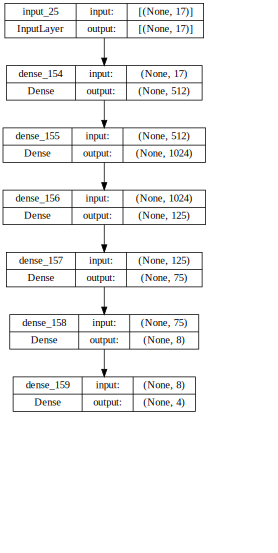

In [290]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

if COLAB:
    display(SVG(model_to_dot(model, show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

## Training

In [291]:
from matplotlib.ticker import MaxNLocator

def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [292]:
acum_tr_acc = []
acum_val_acc = []
best_val_acc = -1000
acum_tr_loss  = []
acum_val_loss = []

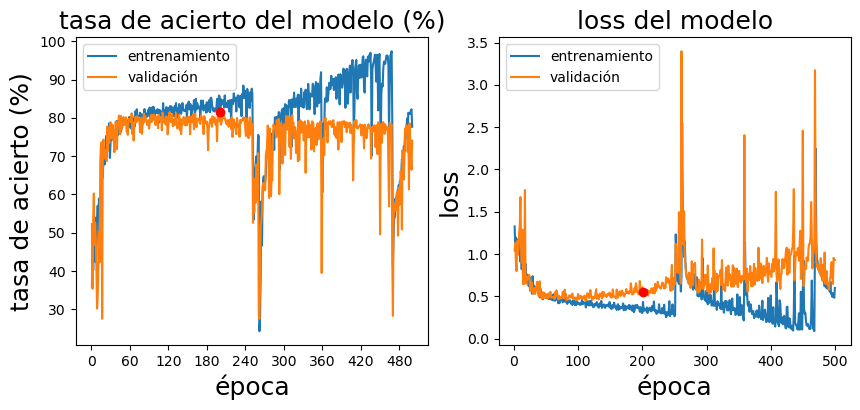

In [293]:
from keras.callbacks import ModelCheckpoint
from IPython.display import SVG, display, clear_output

start = time.perf_counter()
results=pd.DataFrame()
modelpath="model_current_best.h5"

checkpoint = ModelCheckpoint(modelpath, monitor='val_categorical_accuracy', verbose=1,
                             save_best_only=True,
                             mode='max') # graba sólo los que mejoran en validación
callbacks_list = [checkpoint]
for e in range(n_epochs):

    history = model.fit(x_train, t_train, 
                    batch_size = batch_size, 
                    epochs = 1,
                    callbacks=callbacks_list,
                    verbose = 1, 
                    shuffle = True,
                    validation_data = (x_dev, t_dev))
   
    if history.history['val_categorical_accuracy'][-1] > best_val_acc:
        print("Validation accuracy improved from",
            best_val_acc, 'to', history.history['val_categorical_accuracy'])
        print("saving weights")
        best_val_acc = history.history['val_categorical_accuracy'][-1]
        best_model=history.history
        best_time=time.perf_counter() - start
    
    acum_tr_acc.append(history.history['categorical_accuracy'][0])
    acum_val_acc.append(history.history['val_categorical_accuracy'][0])
    acum_tr_loss.append(history.history['loss'][0])
    acum_val_loss.append(history.history['val_loss'][0])
    
    if len(acum_tr_acc) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc)
        grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

    
    results=pd.concat([results,pd.DataFrame(history.history)])
    results_temp = pd.DataFrame(history.history)
    last_model=history.history
    last_time=time.perf_counter() - start

In [295]:
results=results.reset_index(drop=True)

### Best model

In [296]:
print ("Time: ", best_time, "seconds")

human_error = 10
train_error = 100 - (best_model['categorical_accuracy'][0] * 100)
test_error = 100 - (best_model['val_categorical_accuracy'][0] * 100)

print ("Training Set Error: ", train_error, "%")
print ("Development Set Test Error: ", test_error, "%")
print ("Bias: ", train_error - human_error, "%")
print ("Variance: ", test_error - train_error, "%")

Time:  100.31705328799944 seconds
Training Set Error:  20.462125539779663 %
Development Set Test Error:  18.35089921951294 %
Bias:  10.462125539779663 %
Variance:  -2.1112263202667236 %


### Last model

In [297]:
print ("Time: ", last_time, "seconds")

human_error = 10
train_error = 100 - (last_model['categorical_accuracy'][0] * 100)
test_error = 100 - (last_model['val_categorical_accuracy'][0] * 100)

print ("Training Set Error: ", train_error, "%")
print ("Development Set Test Error: ", test_error, "%")
print ("Bias: ", train_error - human_error, "%")
print ("Variance: ", test_error - train_error, "%")

Time:  249.75795522800036 seconds
Training Set Error:  22.33852744102478 %
Development Set Test Error:  25.97644329071045 %
Bias:  12.33852744102478 %
Variance:  3.637915849685669 %


In [131]:
results.head()

,loss,categorical_accuracy,val_loss,val_categorical_accuracy
0,1.291434,0.374738,1.061835,0.493490
1,1.125755,0.454834,1.155076,0.537508
2,1.073465,0.483213,0.865722,0.647861
3,1.327609,0.402574,1.402701,0.275263
4,1.382322,0.294720,1.363700,0.432734


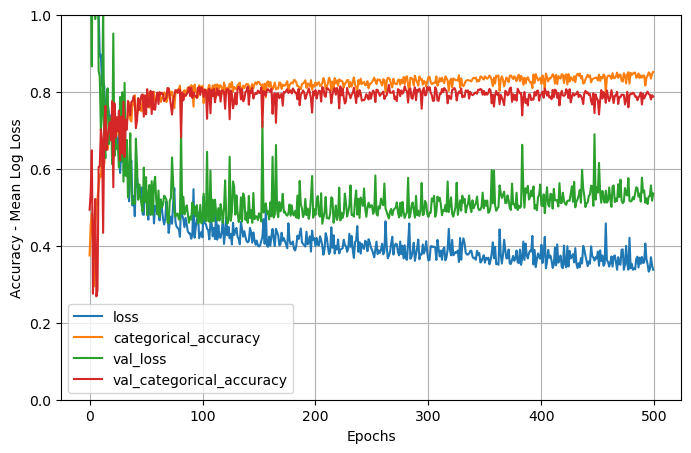

In [132]:
results.plot(figsize = (8, 5))
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy - Mean Log Loss")
plt.gca().set_ylim(0, 1)
plt.show()

### Best model

In [133]:
from keras.models import load_model
best_model = load_model(modelpath)

In [134]:
dev_predictions=best_model.predict(x_dev).round(2)
dev_predictions[:20]

51/51 [==============================] - 0s 1ms/step


array([[0.  , 0.  , 0.29, 0.71],
       [0.  , 0.83, 0.17, 0.  ],
       [0.13, 0.84, 0.03, 0.  ],
       [0.49, 0.5 , 0.01, 0.  ],
       [0.02, 0.43, 0.55, 0.  ],
       [0.  , 0.  , 0.  , 1.  ],
       [0.96, 0.03, 0.  , 0.  ],
       [0.95, 0.04, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  ],
       [0.36, 0.63, 0.01, 0.  ],
       [0.  , 0.89, 0.1 , 0.  ],
       [0.86, 0.14, 0.01, 0.  ],
       [0.01, 0.65, 0.35, 0.  ],
       [0.  , 0.  , 0.5 , 0.5 ],
       [0.17, 0.79, 0.04, 0.  ],
       [0.18, 0.78, 0.03, 0.  ],
       [0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.29, 0.71],
       [0.  , 0.  , 0.01, 0.99],
       [0.99, 0.01, 0.  , 0.  ]], dtype=float32)

In [135]:
dev_rounded_predictions=np.round(dev_predictions)
indices = np.argmax(dev_predictions,1)
for row, index in zip(dev_rounded_predictions, indices): row[index]=1
dev_rounded_predictions[:20]

array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]], dtype=float32)

In [136]:
t_dev[:20] #target classes

,"Poor:[46.0, 62.0]","Interm:[63.0, 66.0]","Good:[67.0, 71.0]","Excel:[72.0, 94.0]"
5703,0.0,0.0,0.0,1.0
12414,0.0,0.0,1.0,0.0
8634,0.0,1.0,0.0,0.0
9379,0.0,1.0,0.0,0.0
10159,0.0,1.0,0.0,0.0
6673,0.0,0.0,0.0,1.0
8069,1.0,0.0,0.0,0.0
7964,0.0,1.0,0.0,0.0
4867,0.0,0.0,0.0,1.0
1997,0.0,1.0,0.0,0.0


In [137]:
dev_correct_predictions = np.equal(np.argmax(dev_rounded_predictions,1),np.argmax(np.array(t_dev),1))
print (dev_correct_predictions[:30])

[ True False  True  True False  True  True False  True  True  True  True
  True  True  True  True  True False  True  True  True  True  True  True
 False  True  True  True  True  True]


In [138]:
from collections import Counter
Counter (dev_correct_predictions)

Counter({True: 1318, False: 295})

### Last model

In [139]:
dev_predictions=model.predict(x_dev).round(2)
dev_predictions[:20]

51/51 [==============================] - 0s 1ms/step


array([[0.  , 0.  , 0.43, 0.57],
       [0.  , 0.89, 0.11, 0.  ],
       [0.11, 0.88, 0.01, 0.  ],
       [0.31, 0.68, 0.01, 0.  ],
       [0.  , 0.18, 0.81, 0.  ],
       [0.  , 0.  , 0.  , 1.  ],
       [0.93, 0.06, 0.  , 0.  ],
       [0.88, 0.11, 0.  , 0.  ],
       [0.  , 0.  , 0.01, 0.99],
       [0.27, 0.72, 0.01, 0.  ],
       [0.01, 0.99, 0.01, 0.  ],
       [0.71, 0.28, 0.01, 0.  ],
       [0.  , 0.61, 0.38, 0.  ],
       [0.  , 0.  , 0.47, 0.53],
       [0.27, 0.72, 0.01, 0.  ],
       [0.28, 0.72, 0.01, 0.  ],
       [0.  , 0.  , 0.01, 0.99],
       [0.  , 0.  , 0.67, 0.33],
       [0.  , 0.  , 0.05, 0.95],
       [0.99, 0.01, 0.  , 0.  ]], dtype=float32)

In [140]:
dev_rounded_predictions=np.round(dev_predictions)
indices = np.argmax(dev_predictions,1)
for row, index in zip(dev_rounded_predictions, indices): row[index]=1
dev_rounded_predictions[:20]

array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]], dtype=float32)

In [141]:
t_dev[:20] #target classes

,"Poor:[46.0, 62.0]","Interm:[63.0, 66.0]","Good:[67.0, 71.0]","Excel:[72.0, 94.0]"
5703,0.0,0.0,0.0,1.0
12414,0.0,0.0,1.0,0.0
8634,0.0,1.0,0.0,0.0
9379,0.0,1.0,0.0,0.0
10159,0.0,1.0,0.0,0.0
6673,0.0,0.0,0.0,1.0
8069,1.0,0.0,0.0,0.0
7964,0.0,1.0,0.0,0.0
4867,0.0,0.0,0.0,1.0
1997,0.0,1.0,0.0,0.0


In [142]:
dev_correct_predictions = np.equal(np.argmax(dev_rounded_predictions,1),np.argmax(np.array(t_dev),1))
print (dev_correct_predictions[:30])

[ True False  True  True False  True  True False  True  True  True  True
  True False  True  True  True  True  True  True False  True  True  True
  True  True  True  True  True False]


In [143]:
from collections import Counter
Counter (dev_correct_predictions)

Counter({True: 1271, False: 342})

## Final Test

### Best_model

In [144]:
final_results = best_model.evaluate(x_final_test, t_final_test)

print ("Final Test Accuracy: ", final_results[1] * 100, "%")

51/51 [==============================] - 0s 2ms/step - loss: 0.4596 - categorical_accuracy: 0.8127
Final Test Accuracy:  81.26550912857056 %


### Last model

In [35]:
final_results = model.evaluate(x_final_test, t_final_test)

print ("Final Test Accuracy: ", final_results[1] * 100, "%")

51/51 [==============================] - 0s 2ms/step - loss: 0.4514 - categorical_accuracy: 0.8139
Final Test Accuracy:  81.38957619667053 %
